# Progressive Dinner Party Mathematical Program

# Setup

### AMPL

In [ ]:
!pip install -q amplpy

In [2]:
# Google Colab & Kaggle integration
MODULES=['ampl', 'gokestrel']
from amplpy import tools
ampl = tools.ampl_notebook(modules=MODULES, globals_=globals()) # instantiate AMPL object and register magics

AMPL License (you can use a free https://ampl.com/ce license):


### Imports

In [16]:
from getpass import getpass

import itertools
import numpy as np
import networkx as nx
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Model

In [4]:
%%writefile pdp.mod
problem progressive_dinner_party;
#--------------------------------

set N;
param C{N,N};
var s{N} binary;
var m{N} binary;
var d{N} binary;
var e{N,N} binary;

minimize objective:
	sum {i in N, j in N} C[i,j]*e[i,j];

subject to classes {i in N}:
	s[i] + m[i] + d[i] = 1;
	
subject to inflow_s {i in N}:
	sum {j in N} s[i] * e[j,i] = 0;
	
subject to outflow_s {i in N}:
	sum {j in N} s[i] * e[i,j] = 3 * s[i];
	
subject to inflow_m {i in N}:
	sum {j in N} m[i] * e[j,i] = 3 * m[i];
	
subject to outflow_m {i in N}:
	sum {j in N} m[i] * e[i,j] = 3 * m[i];
	
subject to inflow_d {i in N}:
	sum {j in N} d[i] * e[j,i] = 3 * d[i];
	
subject to outflow_d {i in N}:
	sum {j in N} d[i] * e[i,j] = 0;
	
subject to shortcut {i in N, j in N}:
	s[i] * e[i,j] + d[j] <= 1;
	
subject to equipartition:
	3 * sum {i in N} m[i] = card(N);

Writing pdp.mod


# Data

In [5]:
w_size = widgets.IntText(description='Size', orientation='horizontal', value=9, min=9)
w_cluster = widgets.IntText(description='Clusters', orientation='horizontal', value=9, min=1)
w_deviation = widgets.FloatText(description='Deviation', orientation='horizontal', value=0.1, min=0)
w_scale = widgets.IntText(description='Scaling', orientation='horizontal', value=1)
display(widgets.Box([w_size, w_cluster,w_deviation, w_scale], layout=widgets.Layout(display='flex', flex_flow='row')))

Box(children=(IntText(value=9, description='Size'), IntText(value=9, description='Clusters'), FloatText(value=…

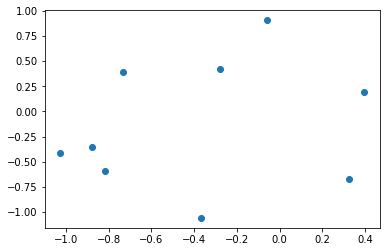

In [6]:
rng = np.random.default_rng()

N = w_size.value
K = w_cluster.value
σ = w_deviation.value
λ = w_scale.value

assert N >= 9
assert K > 0
assert N % K == 0
assert N % 3 == 0
assert σ >= 0
assert λ > 0

points = {}
centers = rng.uniform(-1, 1, (K, 2))
for i in range(K):
	points[str(centers[i])] = λ * rng.normal(centers[i], σ, (N // K, 2))

X = np.array(list(points.values())).reshape(N, 2)[:,0]
Y = np.array(list(points.values())).reshape(N, 2)[:,1]

G = nx.Graph()
for i in range(N):
	G.add_node(i, x = X[i], y = Y[i])

C = np.empty((N,N))
for a,b in itertools.product(range(N), range(N)):
	dX = (X[b]-X[a]) * (X[b]-X[a])
	dY = (Y[b]-Y[a]) * (Y[b]-Y[a])
	C[a,b] = np.sqrt(dX + dY)

with open('pdp.dat', 'w') as f:
	f.write('set N :=')
	for n in range(1, N + 1):
		f.write(f' {n}')
	f.write(';\n')
	f.write('param C :=\n')
	for i,j in itertools.product(range(N), range(N)):
		f.write(f'{i+1} {j+1} {C[i,j]}\n')
	f.write(';')

plt.scatter(X,Y)
plt.show()

In [7]:
with open('pdp.run', 'w') as f:
  f.write("option solver kestrel;\n")
  f.write("option kestrel_options 'solver=octeract';\n")
  f.write(f"option email '{getpass('NEOS MAIL')}';\n")
  f.write("model pdp.mod;\n")
  f.write("data pdp.dat;\n")
  f.write("solve;")

NEOS MAIL··········


In [ ]:
%%ampl_eval
commands pdp.run;

In [72]:
s = ampl.get_variable('s').get_values()
m = ampl.get_variable('m').get_values()
d = ampl.get_variable('d').get_values()
e = ampl.get_variable('e').get_values()

S = np.array(s.get_column('s.val').to_list())
M = np.array(m.get_column('m.val').to_list())
D = np.array(d.get_column('d.val').to_list())
A = np.reshape(e.get_column('e.val').to_list(), (N,N))